#Supervised Resnet


### Import libraries and set constants

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

%matplotlib inline

In [ ]:
INPUT_SIZE = 96
BATCH_SIZE = 128

### Data  augmentation and normalization

In [ ]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_transforms = tt.Compose([tt.RandomCrop(INPUT_SIZE, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                          tt.RandomRotation(10), 
                          tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
test_unlabeled_transforms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

###Loading and formatting datasets

In [ ]:
ds_train = datasets.STL10(
    root="data",
    split='train',
    download=True,
    transform=train_transforms
)


Extracting data/stl10_binary.tar.gz to data


In [ ]:
ds_test = datasets.STL10(
    root="data",
    split='test',
    download=True,
    transform=test_unlabeled_transforms
)

Files already downloaded and verified


In [ ]:
ds_unlabeled = datasets.STL10(
    root="data",
    split='unlabeled',
    download=True,
    transform=test_unlabeled_transforms
)

Files already downloaded and verified


In [ ]:
# Creating dataloaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
dl_unlabeled = DataLoader(ds_unlabeled, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# Display sample
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

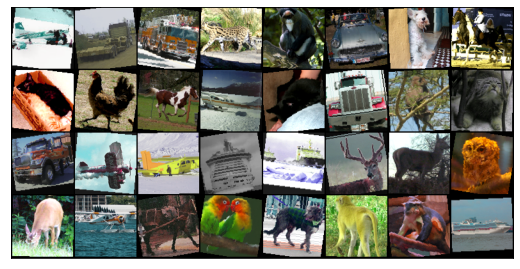

In [ ]:
show_batch(dl_train)

### Set up GPU


In [ ]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Shifitng data
dl_train = DeviceDataLoader(dl_train, device)
dl_test = DeviceDataLoader(dl_test, device)
dl_unlabeled = DeviceDataLoader(dl_unlabeled, device)

In [ ]:
torch.backends.cudnn.benchmark = True

### Framing the ResNet Model

In [ ]:
#Convolution Block
def conv(in_channels, out_channels, kernal_size=3, stride=1, padding=0):
    layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernal_size, stride, padding, bias=False), 
                          nn.BatchNorm2d(out_channels),# Batch normalization removes need for bias
                          nn.ReLU())
    return layer

In [ ]:
#Accuracy Function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# ResNet model
class ResNet(nn.Module):

    def __init__(self, channels=3, classes=10):
        super(ResNet, self).__init__()

        self.is_compiled = False

        # Image size is 3x96x96
        self.conv_1 = conv(channels, 50) # 50x94x94
        self.pool_1 = nn.MaxPool2d(2) # 50x47x47

        # Res #1
        self.res_1 = nn.Sequential(conv(50, 50, padding=1), conv(50, 50, padding=1)) # 50x47x47
        
        # Conv #2
        self.conv_2 = conv(50, 100) # 100x45x45
        self.pool_2 = nn.MaxPool2d(2) # 100x22x22

        # Flatten
        self.flatten = nn.Flatten() # 100*22*22

        # Dropout #1
        self.dropout_1 = nn.Dropout(0.3)

        # Dense #1
        self.dense_1 = nn.Linear(100*22*22, 512)
        
        # Dropout #1
        self.dropout_2 = nn.Dropout(0.3)
        
        # Dense #2
        self.dense_2 = nn.Linear(512, 32) 
        
        # Dropout #3
        self.dropout_3 = nn.Dropout(0.3)

        # Output
        self.out = nn.Linear(32, classes)
    
    def forward(self, input):
        out = self.conv_1(input)
        out = self.pool_1(out)
        out = self.res_1(out) + out
        out = self.conv_2(out)
        out = self.pool_2(out)
        out = self.flatten(out)
        out = self.dropout_1(out)
        out = self.dense_1(out)
        out = self.dropout_2(out)
        out = self.dense_2(out)
        out = self.dropout_3(out)
        out = self.out(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = self.loss_func(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = self.loss_func(out, labels)
        acc = self.accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    @torch.no_grad()
    def evaluate(self, val_loader):
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def compile(self, loss_func=F.cross_entropy, accuracy=accuracy, opt_func=torch.optim.Adam):
        self.is_compiled = True
        self.loss_func = loss_func
        self.accuracy = accuracy
        self.opt_func = opt_func

    def fit(self, train_loader, test_loader, epochs, start_epoch=1, lr = 0.0005):
        if(not self.is_compiled):
            self.compile()
        history = []
        optimizer = self.opt_func(self.parameters(), lr)
        for epoch in range(start_epoch, start_epoch+epochs):
            # Training Phase 
            self.train()
            train_losses = []
            for batch in train_loader:
                loss = self.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none = True)
   

            # Validation phase
            result = self.evaluate(test_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()

            print("Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
                                              .format(epoch, (start_epoch+epochs-1), result['train_loss'], result['val_loss'], result['val_acc']))

            history.append(result)
        return history

### Training the model

In [ ]:
model = ResNet()
model = to_device(model, device)
model

ResNet(
  (conv_1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_1): Sequential(
    (0): Sequential(
      (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv_2): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool_2): MaxPool

In [ ]:
model.compile()

In [ ]:
history = model.fit(dl_train, dl_test,75)

Epoch [1/75], train_loss: 8.3555, val_loss: 3.0694, val_acc: 0.3320
Epoch [2/75], train_loss: 3.3850, val_loss: 2.9104, val_acc: 0.2989
Epoch [3/75], train_loss: 2.6204, val_loss: 1.6347, val_acc: 0.4435
Epoch [4/75], train_loss: 2.0529, val_loss: 2.0282, val_acc: 0.3958
Epoch [5/75], train_loss: 2.0185, val_loss: 1.6847, val_acc: 0.4108
Epoch [6/75], train_loss: 1.9278, val_loss: 1.5503, val_acc: 0.4563
Epoch [7/75], train_loss: 1.7653, val_loss: 1.6091, val_acc: 0.4313
Epoch [8/75], train_loss: 1.6508, val_loss: 1.4845, val_acc: 0.4668
Epoch [9/75], train_loss: 1.6563, val_loss: 1.3410, val_acc: 0.5264
Epoch [10/75], train_loss: 1.5928, val_loss: 1.5012, val_acc: 0.4820
Epoch [11/75], train_loss: 1.5800, val_loss: 1.2657, val_acc: 0.5485
Epoch [12/75], train_loss: 1.4403, val_loss: 1.3282, val_acc: 0.5215
Epoch [13/75], train_loss: 1.4087, val_loss: 1.2571, val_acc: 0.5446
Epoch [14/75], train_loss: 1.4083, val_loss: 1.2021, val_acc: 0.5794
Epoch [15/75], train_loss: 1.3267, val_loss

In [ ]:
torch.save(model.state_dict(), 'ResNetv1')

In [ ]:
# Plot results

def plot(history):
    # Accuracy plot
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()

    # Loss plot
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

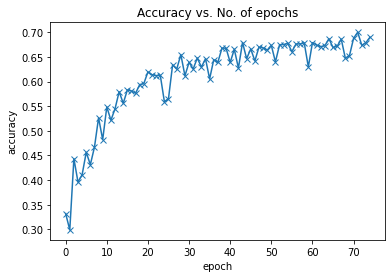

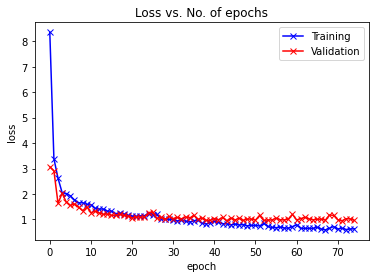

In [ ]:
plot(history)